In [1]:
import bar_chart_race as bcr
import matplotlib.pyplot as plt
import matplotlib

## Datos Covid-19 Colombia

In [5]:
from sodapy import Socrata
import pandas as pd
import numpy as np

In [6]:
def load_colombia_df():
    client = Socrata("www.datos.gov.co", None)  # https://www.datos.gov.co/es/profile/edit/developer_settings   por si no funciona
    results = client.get("gt2j-8ykr", limit=210000)
    results_df = pd.DataFrame.from_records(results)
    return results_df

In [7]:
df_col = load_colombia_df()

In [9]:
def preprocess_df(df):
    df = df.rename(columns={"fecha_diagnostico": "Fecha de diagnóstico",
                            "ciudad_de_ubicaci_n": "ciudad",
                            "fecha_de_notificaci_n": "Fecha de notificacion",
                            "atenci_n": "atencion"})
    
    df["sexo"] = df["sexo"].str.upper()
    df["estado"] = df["estado"].str.upper()
    df["atencion"] = df["atencion"].str.upper()
    df["tipo"] = df["tipo"].str.upper()
    df["edad"] = df["edad"].astype(int)
    
    df["Fecha de diagnóstico"] = pd.to_datetime(df["Fecha de diagnóstico"], errors="coerce")
    df["fecha_recuperado"] = pd.to_datetime(df["fecha_recuperado"], errors="coerce")
    df["fecha_de_muerte"] = pd.to_datetime(df["fecha_de_muerte"], errors="coerce")
    df.loc[df["fis"]=="Asintomático", "estado"] = "ASINTOMATICO"
    df["fis"] = pd.to_datetime(df["fis"], errors="coerce")
    df["tiempo recuperacion"] = df["fecha_recuperado"] - df["fis"]
    df["tiempo recuperacion"] = df["tiempo recuperacion"].dt.days
    
    df["tiempo muerte"] = df["fecha_de_muerte"] - df["fis"]
    df["tiempo muerte"] = df["tiempo muerte"].dt.days
    return df

In [10]:
df_col = preprocess_df(df_col)

In [12]:
def generar_cuenta_colombia(df_data):
    lista = ["Amazonas","Antioquia","Arauca","Atlántico","Bogotá D.C.","Bolívar",
    "Boyacá","Caldas","Caquetá","Casanare","Cauca","Cesar","Chocó",
    "Córdoba","Cundinamarca","Guainía","Guaviare","Huila","La Guajira","Magdalena",
    "Meta","Nariño","Norte de Santander","Putumayo","Quindío","Risaralda","San Andrés y Providencia",
    "Santander","Sucre","Tolima","Valle del Cauca","Vaupés","Vichada"]
    lista = [depto.upper() for depto in lista]
    ceros = [0]*len(lista)
    df_ceros = pd.DataFrame({"NOMBRE_DPT":lista, "cuenta_ceros":ceros})

    # df_data = pd.read_csv("data/Casos1.csv")
    df_data = df_data.rename(columns={"departamento": "NOMBRE_DPT"})
    df_data["NOMBRE_DPT"] = df_data["NOMBRE_DPT"].str.upper()
    df_cuenta = pd.DataFrame(df_data.groupby("NOMBRE_DPT")["id_de_caso"].count()).reset_index().rename(columns={"id_de_caso": "cuenta"})
    
    df_merge = df_ceros.merge(df_cuenta, on="NOMBRE_DPT", how="left")


    df_merge["total"] = df_merge["cuenta"] + df_merge["cuenta_ceros"]
    df_merge = df_merge.drop(["cuenta", "cuenta_ceros"], axis=1)
    nombres_dict = {"BOGOTÁ D.C.": "SANTAFE DE BOGOTA D.C",
                    "VALLE": "VALLE DEL CAUCA"}
    for dept in nombres_dict:
        df_merge = df_merge.replace(dept, nombres_dict[dept])
    df_merge = df_merge.fillna(0)
    df_merge['NOMBRE_DPT'] = df_merge['NOMBRE_DPT'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df_merge = df_merge.replace("NARINO", "NARIÑO")
    return df_merge

In [13]:
df_merge = generar_cuenta_colombia(df_col)

In [15]:
df_col['Fech'] = pd.to_datetime(df_col["Fecha de notificacion"], errors="coerce")

In [17]:
df1 = df_col[['Fech', 'departamento']]

In [19]:
df_dep = pd.pivot_table(df1, index=['Fech'],
                    columns=['departamento'], aggfunc=lambda x: np.count_nonzero(x))

In [21]:
df_dep_ac = df_dep.fillna(0).cumsum()

In [23]:
df_dep_1 = df_dep_ac.fillna(method='ffill')

In [27]:
bcr.bar_chart_race(df_dep_1,'corona_col_20.mp4')

In [24]:
df_dep_1.drop(['Cesar','Tolima','Bolívar','Santander','Magdalena','La Guajira','Cauca','Risaralda','Norte de Santander','Boyacá','Huila','Caldas'], axis=1, inplace=True)

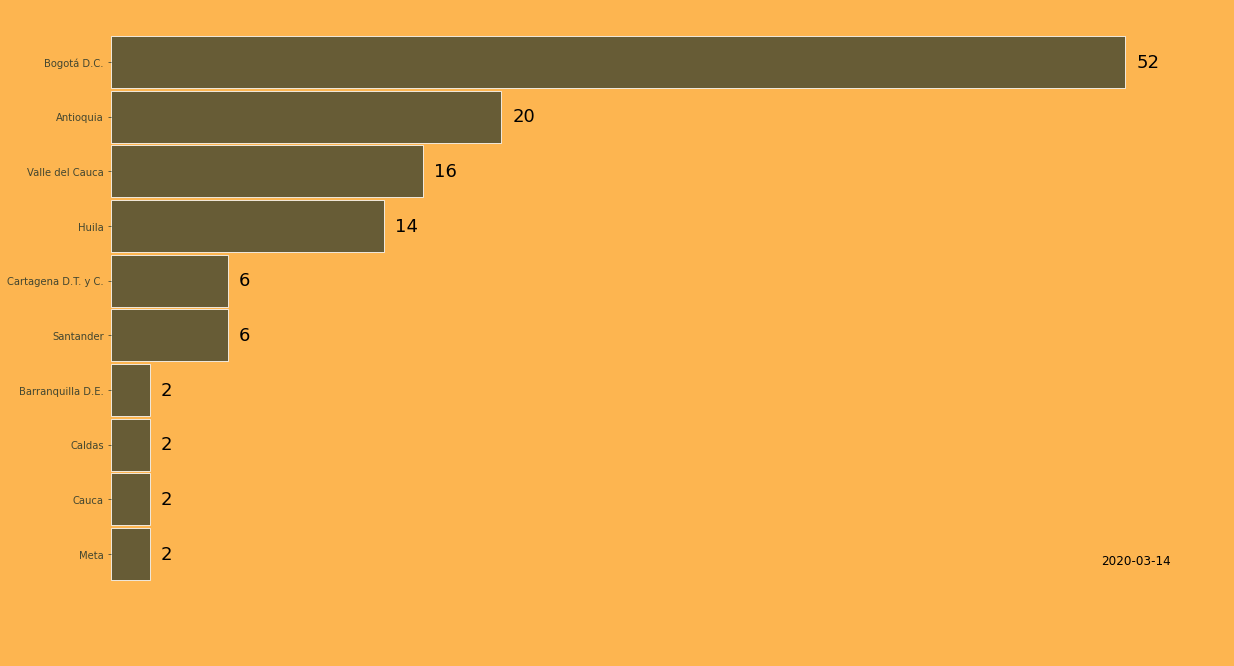

In [26]:
fig, ax = plt.subplots(figsize=(20, 12), facecolor=(253/255, 181/255, 80/255, 1))
ax.set_facecolor((253/255, 181/255, 80/255, 1))
ax.set_xlabel("", fontsize=30)
plt.xticks([])
plt.box(False)
ax.set_ylabel("", fontsize=30)

ax.tick_params(axis='y',which = "major", colors='#424630')

plt.grid(False)
plt.rcParams['axes.grid'] = False

plt.rcParams['font.family'] = 'Florencesans'
bcr.bar_chart_race(df_dep_1.head(10), 'covid_dep_10.mp4', cmap=['#424630'], fig=fig, n_bars=10, bar_label_size=18,tick_label_size=18,)

## Corona paises

In [4]:
df_c = pd.read_csv('../../../data/owid-covid-data.csv').fillna(0)

In [5]:
df_c

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30006,0,0,International,2020-02-28,705.0,0.0,4.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.00,0.0,0.0,0.000,0.0,0.00
30007,0,0,International,2020-02-29,705.0,0.0,6.0,2.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.00,0.0,0.0,0.000,0.0,0.00
30008,0,0,International,2020-03-01,705.0,0.0,6.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.00,0.0,0.0,0.000,0.0,0.00
30009,0,0,International,2020-03-02,705.0,0.0,6.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.00,0.0,0.0,0.000,0.0,0.00


In [6]:
list(df_c.columns)

['iso_code',
 'continent',
 'location',
 'date',
 'total_cases',
 'new_cases',
 'total_deaths',
 'new_deaths',
 'total_cases_per_million',
 'new_cases_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'total_tests',
 'new_tests',
 'total_tests_per_thousand',
 'new_tests_per_thousand',
 'new_tests_smoothed',
 'new_tests_smoothed_per_thousand',
 'tests_units',
 'stringency_index',
 'population',
 'population_density',
 'median_age',
 'aged_65_older',
 'aged_70_older',
 'gdp_per_capita',
 'extreme_poverty',
 'cvd_death_rate',
 'diabetes_prevalence',
 'female_smokers',
 'male_smokers',
 'handwashing_facilities',
 'hospital_beds_per_thousand',
 'life_expectancy']

In [7]:
df_casos = df_c[['date','location','total_cases','total_deaths']]

In [8]:
df_casos

,date,location,total_cases,total_deaths
0,2019-12-31,Afghanistan,0.0,0.0
1,2020-01-01,Afghanistan,0.0,0.0
2,2020-01-02,Afghanistan,0.0,0.0
3,2020-01-03,Afghanistan,0.0,0.0
4,2020-01-04,Afghanistan,0.0,0.0
...,...,...,...,...
30006,2020-02-28,International,705.0,4.0
30007,2020-02-29,International,705.0,6.0
30008,2020-03-01,International,705.0,6.0
30009,2020-03-02,International,705.0,6.0


In [9]:
df_cas = df_casos.pivot_table('total_cases', ['date'], 'location').fillna(0)

In [10]:
df_cas

location,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Western Sahara,World,Yemen,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-09,33653.0,3106.0,17348.0,855.0,386.0,3.0,73.0,83413.0,29820.0,105.0,...,974.0,11259.0,12.0,8010.0,369.0,519.0,12017661.0,1318.0,1895.0,885.0
2020-07-10,33908.0,3188.0,17808.0,855.0,396.0,3.0,73.0,90680.0,30346.0,105.0,...,977.0,11723.0,12.0,8372.0,369.0,519.0,12246269.0,1356.0,1895.0,926.0
2020-07-11,34366.0,3278.0,17808.0,855.0,458.0,3.0,74.0,94047.0,30903.0,105.0,...,985.0,12206.0,12.0,8803.0,370.0,519.0,12476028.0,1380.0,1895.0,942.0


In [11]:
df_sram = df_c.loc[df_c['continent'] == 'South America']

In [12]:
df_sa = df_sram.pivot_table('total_deaths', ['date'], 'location').fillna(0)

In [13]:
df_sa

location,Argentina,Bolivia,Brazil,Chile,Colombia,Ecuador,Falkland Islands,Guyana,Paraguay,Peru,Suriname,Uruguay,Venezuela
date,,,,,,,,,,,,,
2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-09,1654.0,1577.0,67964.0,6573.0,4527.0,4900.0,0.0,16.0,20.0,11133.0,17.0,29.0,75.0
2020-07-10,1707.0,1638.0,69184.0,6682.0,4714.0,4939.0,0.0,16.0,20.0,11314.0,17.0,29.0,80.0
2020-07-11,1749.0,1702.0,70398.0,6781.0,4925.0,4983.0,0.0,16.0,20.0,11500.0,18.0,29.0,83.0


In [14]:
bcr.bar_chart_race(df_sa,'corona_sur_america_muertes.mp4')

In [115]:
df_eur = df_c.loc[df_c['continent'] == 'Europe']
df_eu = df_eur.pivot_table('total_cases', ['date'], 'location').fillna(0)
bcr.bar_chart_race(df_eu,'corona_europa.mp4')

In [116]:
df_eur = df_c.loc[df_c['continent'] == 'Europe']
df_eu = df_eur.pivot_table('total_cases', ['date'], 'location').fillna(0)
bcr.bar_chart_race(df_eu,'corona_europa1.mp4')

KeyboardInterrupt: 